In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import joblib
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
!pip install lightgbm
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix



# Ensure the directories for saving data exist
def create_directories():
    if not os.path.exists('data/'):
        os.makedirs('data/')
        print("Created directory: data/")
    if not os.path.exists('models/'):
        os.makedirs('models/')
        print("Created directory: models/")

create_directories()  # Create the necessary directories


In [4]:
def save_model_instance(instance, filename):
    print(f"Saving model instance: {filename}...")
    np.save(f'/home/dcll/hugging_face_learning/FineTuning_GPT2Model/gpt2_fine_tuned/model/ML-Project-Network_Intrusion_Detection/models/{filename}.npy', instance)

In [5]:
def load_and_split_data(df, target_column='outcome', test_size=0.2, random_state=42):
    print("Loading and splitting the dataset...")
    X = df.drop(target_column, axis=1)  # Features
    Y = df[target_column]  # Target
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)

    # Save the split data
    X_train.to_csv('data/X_train.csv', index=False)
    X_test.to_csv('data/X_test.csv', index=False)
    Y_train.to_csv('data/Y_train.csv', index=False)
    Y_test.to_csv('data/Y_test.csv', index=False)

    print("Data split into training and testing sets.")
    return X_train, X_test, Y_train, Y_test

def categorize_attack_type(label):
    if label in dos_attacks:
        return 'DOS'
    elif label in r2l_attacks:
        return 'R2L'
    elif label in u2r_attacks:
        return 'U2R'
    elif label in probe_attacks:
        return 'probing'
    else:
        return 'normal'
    
df = pd.read_csv('data/data_with_column_names.csv')

dos_attacks = ['smurf.', 'neptune.', 'back.', 'teardrop.', 'pod.', 'land.']
r2l_attacks = ['warezclient.', 'guess_passwd.', 'imap.', 'warezmaster.', 'ftp_write.', 'phf.', 'spy.', 'multihop.']
u2r_attacks = ['buffer_overflow.', 'loadmodule.', 'rootkit.', 'perl.']
probe_attacks = ['satan.', 'ipsweep.', 'portsweep.', 'nmap.']
df['outcome'] = df['outcome'].apply(categorize_attack_type)
target_column = 'outcome'

In [6]:
# One-hot encoding categorical features
def one_hot_encode(X_train, X_test, categorical_columns):
    print("One-hot encoding categorical features...")
    encoders = {}
    X_train_encoded_list = []
    X_test_encoded_list = []
    feature_names = []
    for col in categorical_columns:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_train_col_encoded = encoder.fit_transform(X_train[[col]])
        X_train_encoded_list.append(X_train_col_encoded)
        X_test_col_encoded = encoder.transform(X_test[[col]])
        X_test_encoded_list.append(X_test_col_encoded)
        encoders[col] = encoder
        feature_names.extend(encoder.get_feature_names_out([col]))
        save_model_instance(encoder, f'encoder_{col}')
    
    X_train_encoded = np.concatenate(X_train_encoded_list, axis=1)
    X_test_encoded = np.concatenate(X_test_encoded_list, axis=1)

    X_train_remaining = X_train.drop(columns=categorical_columns)
    X_test_remaining = X_test.drop(columns=categorical_columns)
    
    X_train_final = np.concatenate([X_train_remaining.values, X_train_encoded], axis=1)
    X_test_final = np.concatenate([X_test_remaining.values, X_test_encoded], axis=1)
    
    if not os.path.exists('data'):
        os.makedirs('data')

    np.save('data/X_train_encoded.npy', X_train_final)
    np.save('data/X_test_encoded.npy', X_test_final)

    print("Categorical features encoded and original columns removed.")
    return X_train_final, X_test_final, encoders

categorical_columns = ['protocol_type', 'service', 'flag']

In [7]:
# Apply Robust Scaling
def robust_scale(X_train, X_test):
    print("Applying robust scaling...")
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    np.save('data/X_train_scaled.npy', X_train_scaled)
    np.save('data/X_test_scaled.npy', X_test_scaled)
    print("Data scaled using RobustScaler.")
    save_model_instance(scaler, 'scaler')
    return X_train_scaled, X_test_scaled, scaler

In [8]:
# Apply SMOTEENN resampling
def apply_smoteenn(X_train, Y_train):
    print("Applying SMOTEENN for resampling...")
    smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
    X_train_resampled, Y_train_resampled = smote_enn.fit_resample(X_train, Y_train)
    np.save('data/X_train_resampled.npy', X_train_resampled)
    np.save('data/Y_train_resampled.npy', Y_train_resampled)
    print("Data resampled using SMOTEENN.")
    print(f"Resampled Y distribution: {Counter(Y_train_resampled)}")
    resampled_data = pd.DataFrame(X_train_resampled)
    resampled_data['outcome'] = Y_train_resampled
    resampled_data.to_csv('resampled_data.csv', index=False)
    return X_train_resampled, Y_train_resampled

In [9]:
def feature_selection(X_train, Y_train, variance_threshold=0.01, k_best=20, correlation_threshold=0.1):
    print("Starting feature selection...")
    vt = VarianceThreshold(threshold=variance_threshold)
    X_train_var = vt.fit_transform(X_train)
    correlation_matrix = pd.DataFrame(X_train_var).corrwith(pd.Series(Y_train))
    low_corr_features = correlation_matrix[correlation_matrix.abs() < correlation_threshold].index
    np.save('data/low_corr_features.npy', low_corr_features)
    X_train_var = np.delete(X_train_var, low_corr_features, axis=1)
    print(f"Removed low correlation features: {low_corr_features.tolist()}")
    corr_matrix = pd.DataFrame(X_train_var).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    np.save('data/high_corr_features.npy', to_drop)
    X_train_var = np.delete(X_train_var, to_drop, axis=1)
    print(f"Removed highly correlated features: {to_drop}")
    selector = SelectKBest(mutual_info_classif, k=k_best)
    X_train_selected = selector.fit_transform(X_train_var, Y_train)
    np.save('data/X_train_selected.npy', X_train_selected)
    print(f"Selected {k_best} best features using mutual information.")
    save_model_instance(selector, 'selector')
    return X_train_selected, selector

In [10]:
# #CODE FOR OULTLIER REMOVAL(NOT DEPLOYED)

# import numpy as np
# import pandas as pd
# from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.covariance import EllipticEnvelope
# from sklearn.preprocessing import LabelEncoder, RobustScaler
# from sklearn.metrics import classification_report, accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split

# # Example data: Replace this with your actual data
# # df = pd.read_csv('your_data.csv')
# # Assuming df is your dataframe with features and 'outcome' column as the target
# X = df.drop('outcome', axis=1)
# Y = df['outcome']

# # Split into train and test sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# # Apply one-hot encoding to categorical features
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# X_train_1 = encoder.fit_transform(X_train[['protocol_type']])
# X_test_1 = encoder.transform(X_test[['protocol_type']])

# X_train_2 = encoder.fit_transform(X_train[['service']])
# X_test_2 = encoder.transform(X_test[['service']])

# X_train_3 = encoder.fit_transform(X_train[['flag']])
# X_test_3 = encoder.transform(X_test[['flag']])

# # Concatenate encoded and numeric features
# X_train_combined = np.concatenate([X_train_1, X_train_2, X_train_3, X_train.drop(['protocol_type', 'service', 'flag'], axis=1).values], axis=1)
# X_test_combined = np.concatenate([X_test_1, X_test_2, X_test_3, X_test.drop(['protocol_type', 'service', 'flag'], axis=1).values], axis=1)

# # Initialize RobustScaler and apply it to the training set
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train_combined)
# X_test_scaled = scaler.transform(X_test_combined)

# # Encode the target variable
# label_encoder = LabelEncoder()
# Y_train_encoded = label_encoder.fit_transform(Y_train)
# Y_test_encoded = label_encoder.transform(Y_test)

# # --------------------------------
# # Step 1: Detect Outliers (Isolation Forest, LOF, Elliptic Envelope)
# # --------------------------------

# # Isolation Forest
# iso_forest = IsolationForest(contamination=0.1, random_state=42)
# iso_forest.fit(X_train_scaled)
# train_iso_pred = iso_forest.predict(X_train_scaled)
# test_iso_pred = iso_forest.predict(X_test_scaled)

# # Local Outlier Factor (LOF)
# lof = LocalOutlierFactor(contamination=0.1)
# train_lof_pred = lof.fit_predict(X_train_scaled)

# # Elliptic Envelope
# elliptic = EllipticEnvelope(contamination=0.1)
# elliptic.fit(X_train_scaled)
# train_elliptic_pred = elliptic.predict(X_train_scaled)
# test_elliptic_pred = elliptic.predict(X_test_scaled)

# # Convert outliers (-1) to 1, inliers (1) to 0 for binary classification
# train_iso_pred[train_iso_pred == 1] = 0
# train_iso_pred[train_iso_pred == -1] = 1
# test_iso_pred[test_iso_pred == 1] = 0
# test_iso_pred[test_iso_pred == -1] = 1

# train_lof_pred[train_lof_pred == 1] = 0
# train_lof_pred[train_lof_pred == -1] = 1

# train_elliptic_pred[train_elliptic_pred == 1] = 0
# train_elliptic_pred[train_elliptic_pred == -1] = 1
# test_elliptic_pred[test_elliptic_pred == 1] = 0
# test_elliptic_pred[test_elliptic_pred == -1] = 1

# # --------------------------------
# # Step 2: Remove Outliers Based on Isolation Forest
# # --------------------------------

# # Filter out outliers (where prediction is 0)
# X_train_cleaned = X_train_scaled[train_iso_pred == 0]
# Y_train_cleaned = Y_train_encoded[train_iso_pred == 0]

# X_test_cleaned = X_test_scaled[test_iso_pred == 0]
# Y_test_cleaned = Y_test_encoded[test_iso_pred == 0]

# # --------------------------------
# # Step 3: Train Classifier After Removing Outliers
# # --------------------------------

# # Example classifier: Logistic Regression
# clf = LogisticRegression(random_state=42)
# clf.fit(X_train_cleaned, Y_train_cleaned)

# # Make predictions on cleaned test set
# predictions = clf.predict(X_test_cleaned)

# # Evaluate the model
# print('Classification Report:')
# print(classification_report(Y_test_cleaned, predictions, zero_division=0))

# accuracy = accuracy_score(Y_test_cleaned, predictions)
# print(f"Model Accuracy: {accuracy:.4f}")

# # --------------------------------
# # Optional: Try LOF and Elliptic Envelope to Clean Data
# # --------------------------------
# # For LOF or Elliptic Envelope, follow a similar approach:
# # - Use the predictions from the models (train_lof_pred or train_elliptic_pred)
# # - Filter out the outliers and retrain the classifier


In [11]:
# Complete pipeline function to execute all steps
def complete_preprocessing_pipeline(df, target_column, categorical_columns):
    if not os.path.exists('data/resampled_data.csv'):
        print("Resampled data not found. Applying preprocessing steps...")
        create_directories()
        X_train, X_test, Y_train, Y_test = load_and_split_data(df, target_column)
        X_train_encoded, X_test_encoded, encoders = one_hot_encode(X_train, X_test, categorical_columns)
        X_train_scaled, X_test_scaled, scaler = robust_scale(X_train_encoded, X_test_encoded)
        test_data = pd.DataFrame(X_test_scaled)
        test_data['outcome'] = Y_test
        test_data.to_csv('test_data.csv', index=False)
        X_train_resampled, Y_train_resampled = apply_smoteenn(X_train_scaled, Y_train)
    else:
        print("Resampled data found. Skipping preprocessing steps...")
        resampled_data = pd.read_csv('data/resampled_data.csv')
        X_train_resampled = resampled_data.drop('outcome', axis=1)
        Y_train_resampled = resampled_data['outcome']
        label_encoder = LabelEncoder()
        Y_train_resampled = label_encoder.fit_transform(Y_train_resampled)
        save_model_instance(label_encoder, 'label_encoder')
    X_train_selected, selector = feature_selection(X_train_resampled, Y_train_resampled)
    selected_data = pd.DataFrame(X_train_selected)
    selected_data['outcome'] = Y_train_resampled
    selected_data.to_csv('selected_data.csv', index=False)

In [12]:
complete_preprocessing_pipeline(df, target_column='outcome', categorical_columns=categorical_columns)

Resampled data found. Skipping preprocessing steps...
Saving model instance: label_encoder...


In [13]:
def load_model_instance(filename):
    print(f"Loading model instance: {filename}...")
    return np.load(f'models/{filename}.npy', allow_pickle=True).item()

selector = load_model_instance('selector')

Loading model instance: selector...


/home/dcll/anaconda3/envs/pytorch-cuda11.1/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SelectKBest from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
Train_data = pd.read_csv('data/selected_data.csv')
Test_data = pd.read_csv('data/test_data.csv')

X_train_selected = Train_data.drop('outcome', axis=1)
Y_train_resampled = Train_data['outcome']

In [15]:
selected_features = selector.get_support(indices=True)
selected_features = [i for i in selected_features if i < len(Train_data.columns)]
selected_feature_names = Train_data.columns[selected_features]
print(selected_feature_names)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '19', 'outcome'],
      dtype='object')


In [16]:
#this addded to reinstantiate Y_test
X_train_temp, X_test_temp, Y_train_temp, Y_test = load_and_split_data(df, target_column)

Loading and splitting the dataset...
Data split into training and testing sets.


In [29]:
X_test = np.load('data/X_test_scaled.npy')
selected_data = pd.read_csv('data/selected_data.csv')
selected_columns = selected_data.columns.tolist()
selected_columns.remove('outcome')
selected_indices = [selected_data.columns.get_loc(col) for col in selected_columns]
X_test_selected = X_test[:, selected_indices]
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_columns)
X_test_selected['outcome'] = Y_test

print(type(X_train_selected))
print(type(X_test_selected))
if isinstance(X_train_selected, pd.DataFrame) and isinstance(X_test_selected, pd.DataFrame):
    print("Converting selected data to numpy arrays...")
    X_test_selected = X_test_selected[X_train_selected.columns]
label_encoder = load_model_instance('label_encoder')
Y_test_encoded = label_encoder.fit_transform(Y_test)
Y_test_encoded = pd.Series(Y_test_encoded)
print(Y_test_encoded.value_counts())
print(Y_train_resampled.value_counts())

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Converting selected data to numpy arrays...
Loading model instance: label_encoder...
0    78292
3    19456
4      822
1      225
2       10
Name: count, dtype: int64
outcome
4    313002
2    312997
0    312966
1    312253
3    311917
Name: count, dtype: int64


In [23]:
# apply vanila perceptron model for multiclass classification
clf = Perceptron()
clf.fit(X_train_selected, Y_train_resampled)
X_test_selected = X_test_selected[:len(Y_test)]

label_encoder = load_model_instance('label_encoder')
Y_test_encoded = label_encoder.fit_transform(Y_test)
Y_test_encoded = pd.Series(Y_test_encoded)
predictions = clf.predict(X_test_selected)

print(Y_test.value_counts())
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))

accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Model Accuracy: {accuracy:.4f}")

Loading model instance: label_encoder...
outcome
DOS        78292
normal     19456
probing      822
R2L          225
U2R           10
Name: count, dtype: int64
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     78292
           1       0.01      0.02      0.01       225
           2       0.00      1.00      0.00        10
           3       0.50      0.00      0.00     19456
           4       0.05      0.44      0.09       822

    accuracy                           0.72     98805
   macro avg       0.31      0.47      0.21     98805
weighted avg       0.87      0.72      0.74     98805

Model Accuracy: 0.7223


Loading model instance: label_encoder...


/home/dcll/anaconda3/envs/pytorch-cuda11.1/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator Perceptron from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


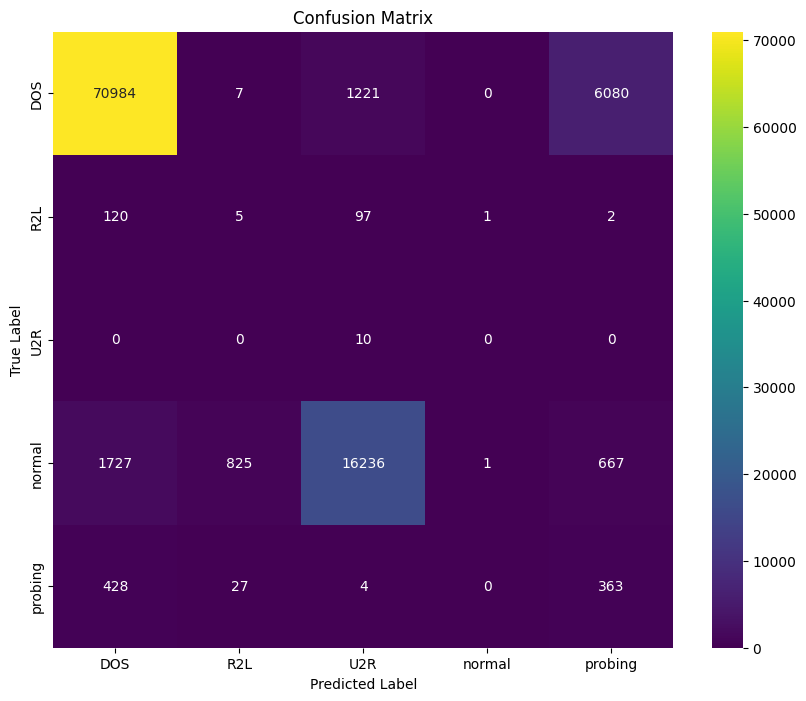

In [43]:
#plot confusion matrix for perceptron model
# label_encoder = load_model_instance('label_encoder')
# Y_test_encoded = label_encoder.fit_transform(Y_test)
# Y_test_encoded = pd.Series(Y_test_encoded)
#LOAD perceptron model from perceptronmodel.pkl
clf = joblib.load('perceptronmodel.pkl')
predictions = clf.predict(X_test_selected)
cm = confusion_matrix(Y_test_encoded, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [49]:
joblib.dump(clf, 'perceptronmodel.pkl')
print("Model saved as perceptronmodel.pkl.")

Model saved as perceptronmodel.pkl.


ROC-AUC Score (Macro Average): 0.725490899314572
ROC-AUC Score (Micro Average): 0.8485725815888923


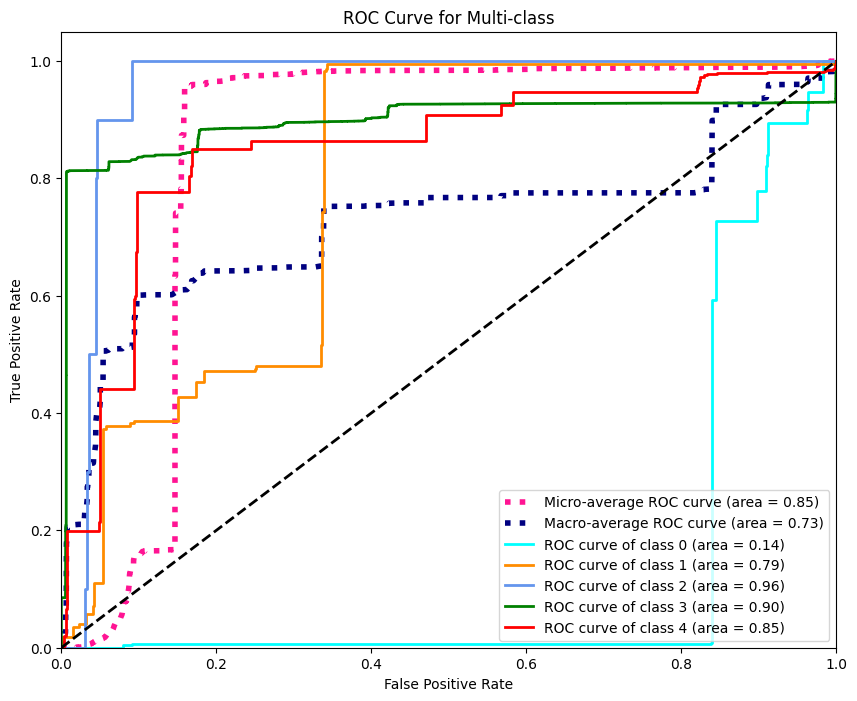

y_test_binarized shape: (98805, 5)
y_score shape: (98805, 5)


In [29]:
y_test_binarized = label_binarize(Y_test_encoded, classes=np.unique(Y_test_encoded))
y_score = clf.decision_function(X_test_selected)
roc_auc_macro = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
roc_auc_micro = roc_auc_score(y_test_binarized, y_score, average='micro', multi_class='ovr')
print("ROC-AUC Score (Macro Average):", roc_auc_macro)
print("ROC-AUC Score (Micro Average):", roc_auc_micro)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()
print("y_test_binarized shape:", y_test_binarized.shape)
print("y_score shape:", y_score.shape)


In [36]:
clf = DecisionTreeClassifier()
clf.fit(X_train_selected, Y_train_resampled)
predictions = clf.predict(X_test_selected)
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))
accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Model Accuracy: {accuracy:.4f}")
joblib.dump(clf, 'decisiontreemodel.pkl')
print("Model saved as decisiontreemodel.pkl.")

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     78292
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00        10
           3       0.98      0.29      0.45     19456
           4       0.00      0.00      0.00       822

    accuracy                           0.85     98805
   macro avg       0.36      0.26      0.27     98805
weighted avg       0.86      0.85      0.81     98805

Model Accuracy: 0.8456
Model saved as decisiontreemodel.pkl.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


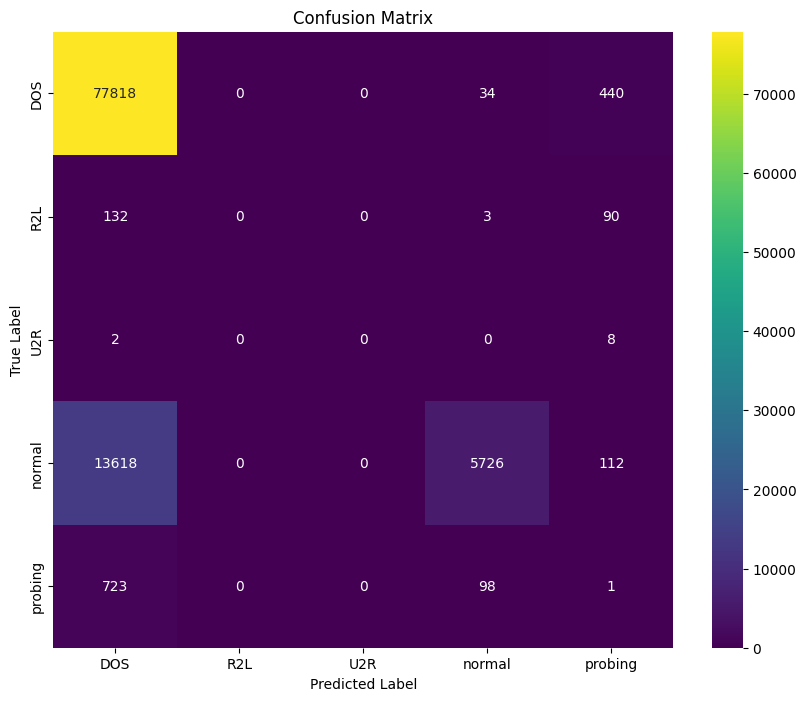

In [40]:
cm = confusion_matrix(Y_test_encoded, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

ROC-AUC Score (Macro Average): 0.5575482161201782
ROC-AUC Score (Micro Average): 0.9034714842366277


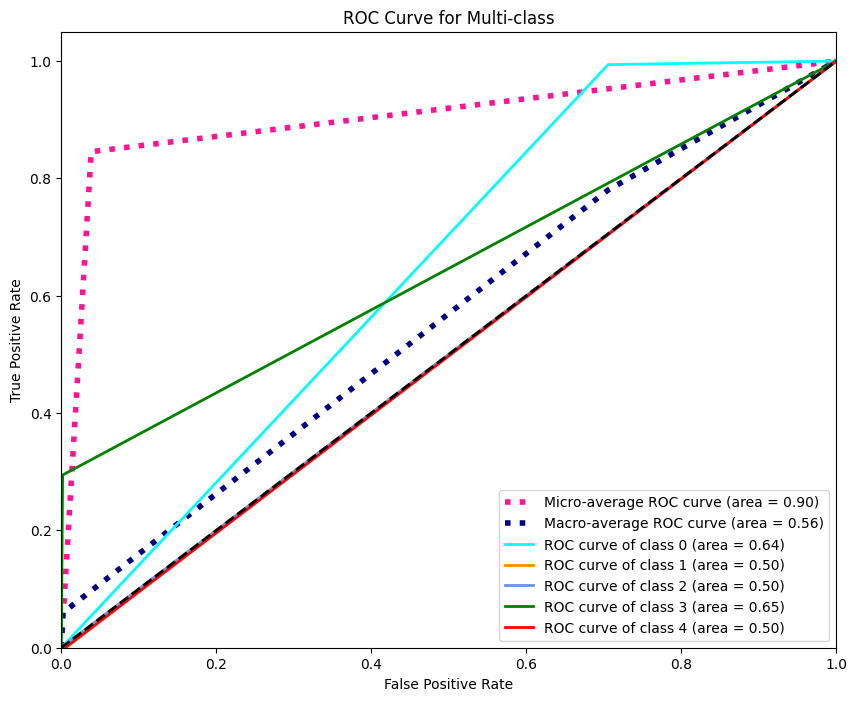

y_test_binarized shape: (98805, 5)
y_score shape: (98805, 5)


In [38]:
y_test_binarized = label_binarize(Y_test_encoded, classes=np.unique(Y_test_encoded))
y_score = clf.predict_proba(X_test_selected)
roc_auc_macro = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
roc_auc_micro = roc_auc_score(y_test_binarized, y_score, average='micro', multi_class='ovr')
print("ROC-AUC Score (Macro Average):", roc_auc_macro)
print("ROC-AUC Score (Micro Average):", roc_auc_micro)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()

print("y_test_binarized shape:", y_test_binarized.shape)
print("y_score shape:", y_score.shape)


In [53]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100
)
clf.fit(X_train_selected, Y_train_resampled)
predictions = clf.predict(X_test_selected)
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))
accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Model Accuracy: {accuracy:.4f}")
joblib.dump(clf, 'softmaxregressionmodel.pkl')
print("Model saved as softmaxregressionmodel.pkl.")

/home/dcll/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     78292
           1       0.01      0.04      0.02       225
           2       0.00      1.00      0.00        10
           3       0.00      0.00      0.00     19456
           4       0.00      0.00      0.00       822

    accuracy                           0.79     98805
   macro avg       0.19      0.41      0.20     98805
weighted avg       0.75      0.79      0.77     98805

Model Accuracy: 0.7860
Model saved as softmaxregressionmodel.pkl.


/home/dcll/anaconda3/envs/pytorch-cuda11.1/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ROC-AUC Score (Macro Average): 0.6863587314065953
ROC-AUC Score (Micro Average): 0.7900235246548719


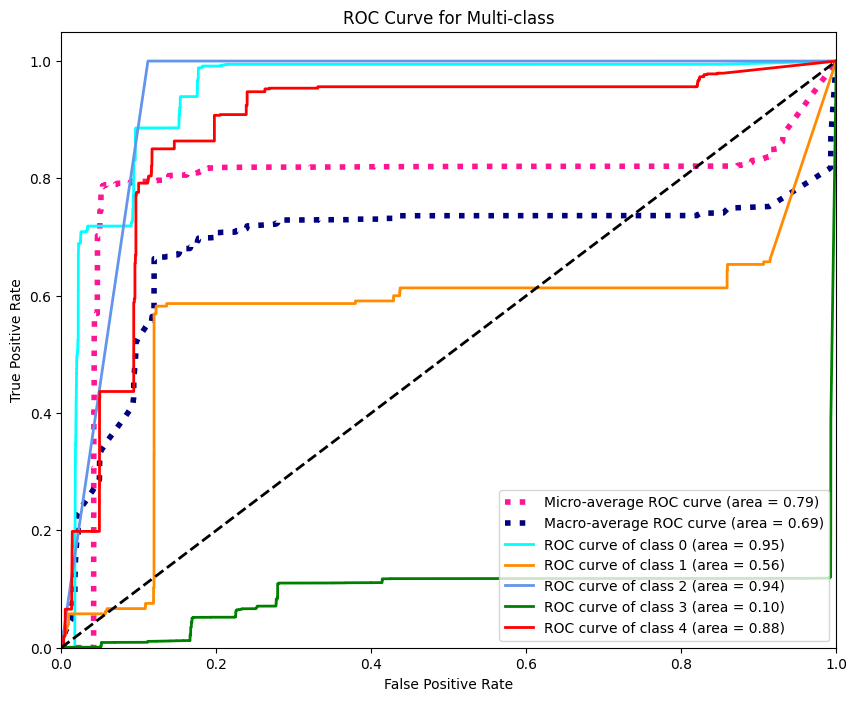

y_test_binarized shape: (98805, 5)
y_score shape: (98805, 5)


In [44]:
#load softmax regression model from softmaxregressionmodel.pkl
clf = joblib.load('softmaxregressionmodel.pkl')
y_test_binarized = label_binarize(Y_test_encoded, classes=np.unique(Y_test_encoded))
y_score = clf.predict_proba(X_test_selected)
roc_auc_macro = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
roc_auc_micro = roc_auc_score(y_test_binarized, y_score, average='micro', multi_class='ovr')
print("ROC-AUC Score (Macro Average):", roc_auc_macro)
print("ROC-AUC Score (Micro Average):", roc_auc_micro)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()
print("y_test_binarized shape:", y_test_binarized.shape)
print("y_score shape:", y_score.shape)


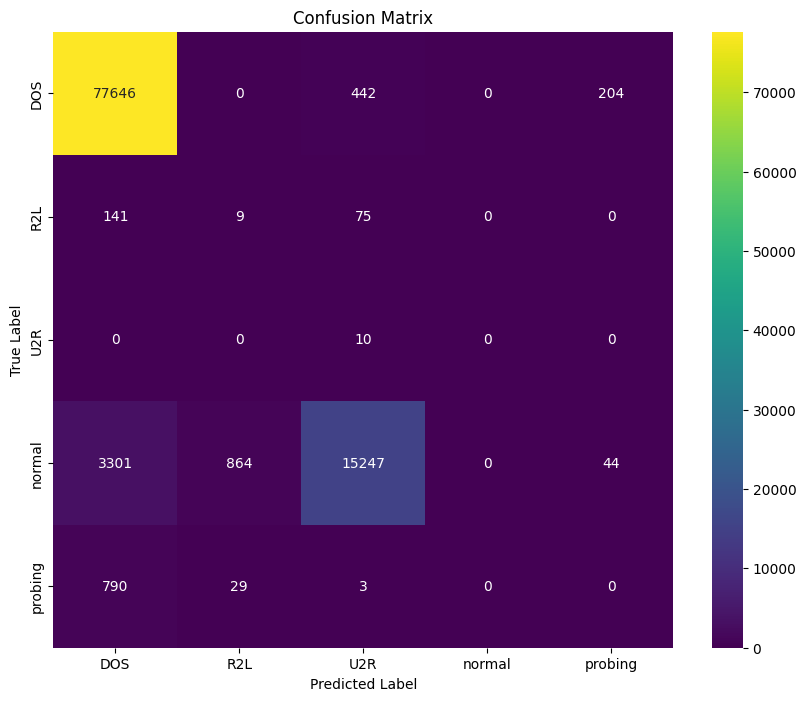

In [46]:
predictions = clf.predict(X_test_selected)
cm = confusion_matrix(Y_test_encoded, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.288244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4849
[LightGBM] [Info] Number of data points in the train set: 1563135, number of used features: 20
[LightGBM] [Info] Start training from score -1.608354
[LightGBM] [Info] Start training from score -1.610635
[LightGBM] [Info] Start training from score -1.608255
[LightGBM] [Info] Start training from score -1.611712
[LightGBM] [Info] Start training from score -1.608239
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     78292
           1       0.48      0.09      0.15       225
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00     19456
           4       0.00      0.00      0.00       822

    accuracy              

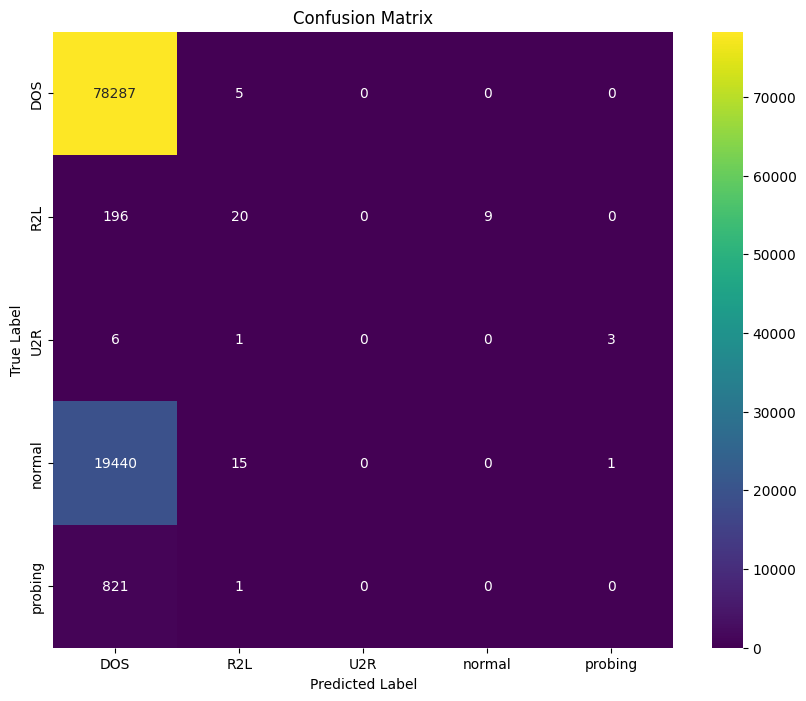

In [32]:
train_data = lgb.Dataset(X_train_selected, label=Y_train_resampled)
test_data = lgb.Dataset(X_test_selected, label=Y_test_encoded, reference=train_data)
params = {
    'objective': 'multiclass',
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'num_class': len(set(Y_train_resampled)),
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9
}
model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, test_data])
predictions_proba = model.predict(X_test_selected, num_iteration=model.best_iteration)
predictions = [list(proba).index(max(proba)) for proba in predictions_proba]
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))
accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Model Accuracy: {accuracy:.4f}")
joblib.dump(model, 'lightgbm_model.pkl')
print("Model saved as lightgbm_model.pkl.")
cm = confusion_matrix(Y_test_encoded, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

ROC-AUC Score (Macro Average): 0.8954656476918552
ROC-AUC Score (Micro Average): 0.9732719010750402


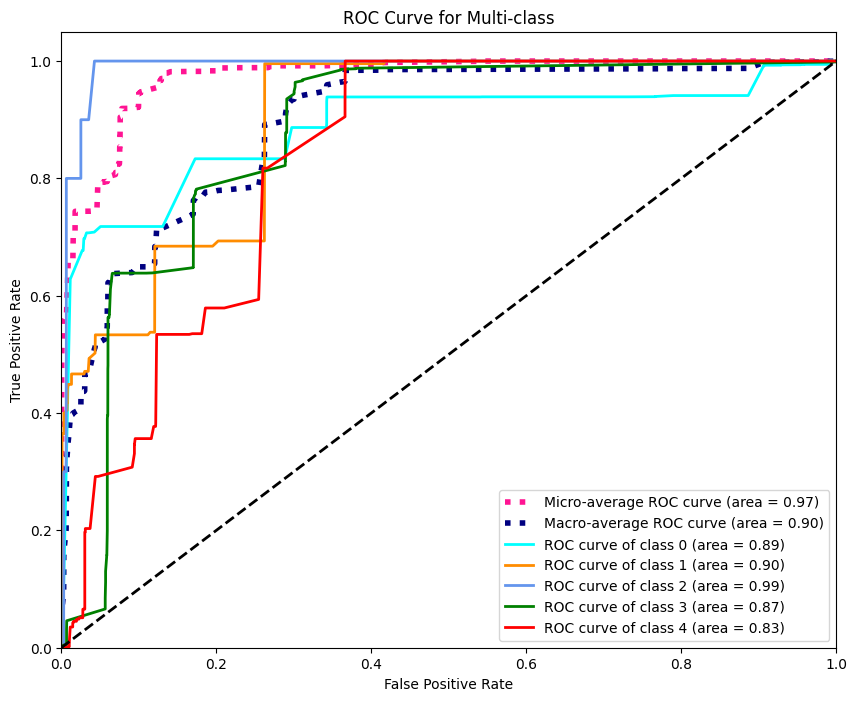

y_test_binarized shape: (98805, 5)
y_score shape: (98805, 5)


In [41]:
y_test_binarized = label_binarize(Y_test_encoded, classes=np.unique(Y_test_encoded))
y_score = model.predict(X_test_selected)
roc_auc_macro = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
roc_auc_micro = roc_auc_score(y_test_binarized, y_score, average='micro', multi_class='ovr')
print("ROC-AUC Score (Macro Average):", roc_auc_macro)
print("ROC-AUC Score (Micro Average):", roc_auc_micro)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()
print("y_test_binarized shape:", y_test_binarized.shape)
print("y_score shape:", y_score.shape)


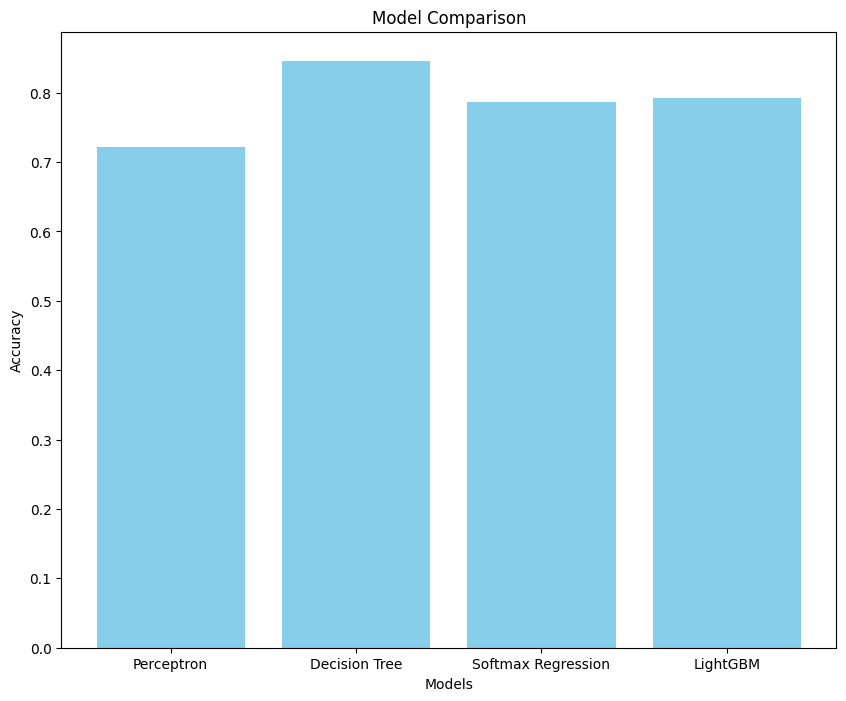

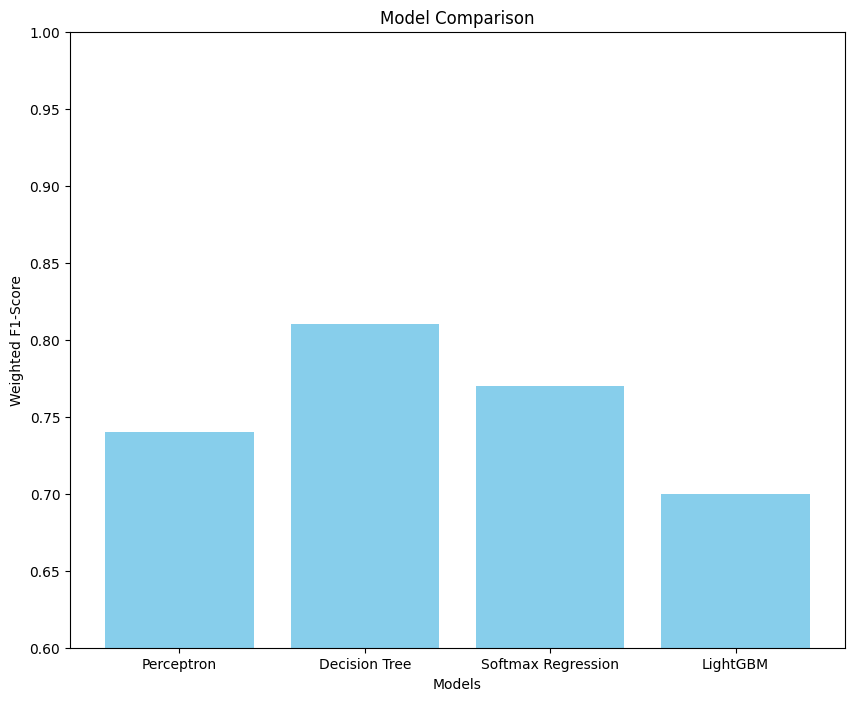

In [44]:
#plot comparision of softmax regression, decision tree, perceptron and lightgbm models
models = ['Perceptron', 'Decision Tree', 'Softmax Regression', 'LightGBM']
accuracies = [0.7223, 0.8456, 0.786, 0.7925]
x = np.arange(len(models))
plt.figure(figsize=(10, 8))
plt.bar(x, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.xticks(x, models)
plt.show()

weighted_f1_scores = [0.74,0.81,0.77,0.70]
plt.figure(figsize=(10, 8))
plt.bar(x, weighted_f1_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Weighted F1-Score')
plt.title('Model Comparison')
plt.xticks(x, models)
plt.ylim(0.6, 1)
plt.show()

In [ ]:
#plot confusion matrix for softmax regression model
from sklearn.metrics import confusion_matrix

predictions = clf.predict(X_test_selected)

# Compute confusion matrix
cm = confusion_matrix(Y_test_encoded, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()